# Exploração Inicial

## Explorando o dataset

Caminho para os videos de treinamento:
    "../chalearn_dataset/train/{nome_video}.mp4"

In [1]:
data_path = "../chalearn_dataset"

In [2]:
import pandas as pd

data_training = pd.read_pickle(f"{data_path}/train/annotation_training.pkl")
df_training = pd.DataFrame.from_dict(data_training)

df_training.head(10)

,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
J4GQm9j0JZ0.003.mp4,0.523364,0.552083,0.626374,0.601942,0.504673,0.488889
zEyRyTnIw5I.005.mp4,0.345794,0.375000,0.472527,0.582524,0.457944,0.366667
nskJh7v6v1U.004.mp4,0.252336,0.291667,0.406593,0.485437,0.373832,0.511111
6wHQsN5g2RM.000.mp4,0.457944,0.489583,0.505495,0.398058,0.457944,0.377778
dQOeQYWIgm8.000.mp4,0.607477,0.489583,0.406593,0.621359,0.570093,0.622222
eHcRre1YsNA.000.mp4,0.196262,0.302083,0.351648,0.262136,0.214953,0.566667
vZpneJlniAE.005.mp4,0.420561,0.635417,0.571429,0.466019,0.532710,0.633333
oANKg9_grdA.004.mp4,0.429907,0.583333,0.626374,0.582524,0.551402,0.588889
VuadgOz6T7s.000.mp4,0.224299,0.135417,0.153846,0.145631,0.140187,0.233333
7nhJXn9PI0I.001.mp4,0.177570,0.197917,0.186813,0.417476,0.224299,0.355556


## Como usar o vídeo

### Conteúdo visual:

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
# Extrai um número fixo de frames igualmente espaçados de um vídeo
def extract_video_frames(video_path, n=16, dim=(224, 224)):
  cap = cv2.VideoCapture(video_path)
  frames = []
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  jump_size = int(length // number_of_frames)
  for _ in range(number_of_frames):
    ret, frame = cap.read()
    frames.append(cv2.cvtColor(cv2.resize(frame, dim), cv2.COLOR_BGR2RGB))
    for __ in range(jump_size - 1):
      cap.grab()
  return np.array(frames)

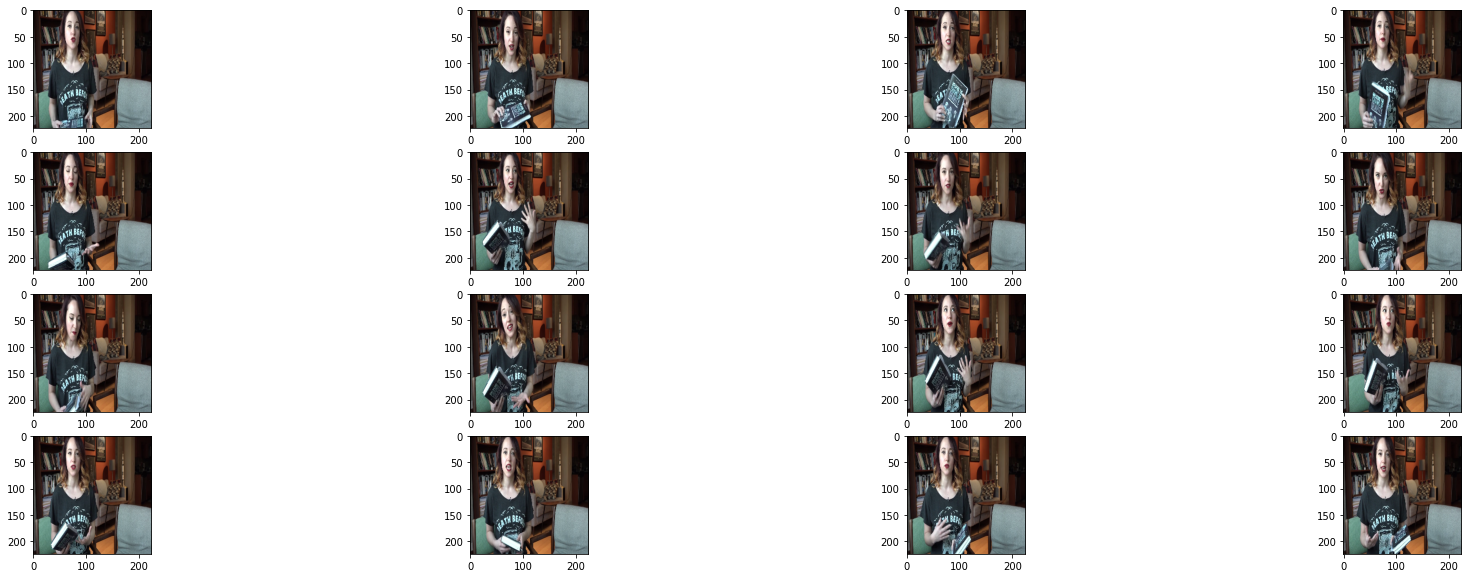

In [5]:
video_path = f"{data_path}/train/_uNup91ZYw0.002.mp4"
number_of_frames=16

frames = extract_video_frames(video_path, number_of_frames)

# Plotando o resultado:
fig = plt.figure(figsize=(30, 10))
rows = 4
columns = 4
for _ in range(number_of_frames):
  fig.add_subplot(rows, columns, _ + 1)
  plt.imshow(frames[_])

In [6]:
# forma da sequência de frames (resultado de extract_video_frames)
print(frames.shape)

(16, 224, 224, 3)


In [8]:
# Concatena a saída de frames lado a lado (é a melhor solução?)
# def concatenate_frames(frames):
#     return frames.reshape(int(frames.shape[0] ** 0.5) * frames.shape[1],int(frames.shape[0] ** 0.5) * frames.shape[2], frames.shape[3])
# print(concatenate_frames(frames).shape)

## Preparando um modelo

Modelo baseado no classificador de imagens descrito em: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [14]:
# Precisamos de uma ferramenta do TensorFlow e do TensorFlow Addons
# Executar essa célula quando precisar instalar na máquina que roda o modelo
# ! pip install -U tensorflow-addons
# ! pip install -U tensorflow

In [8]:
# Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [9]:
# Hyperparamters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
# Implement a Multi Layer Perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
'''
Implement a patches creation as a layer.

Implementação de uma camada (inicial) que será responsável pela criação de patches (recortar as 
imagens em pequenos tokens) a partir da entrada.

TODO:
    - Entrada atual: 1 imagem 
    - Saída: tokens - imagem recortada
    
    FAZER:
        entrada: uma sequência de imagens,
        saída: tokens desta imagem.
    
'''
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = frames[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


2022-04-04 22:57:30.140209: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 22:57:30.895228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11005 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:04:00.0, compute capability: 6.1


Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


## Implementando uma camada de Patch Encodding

A ideia aqui é projetar um patch em um vetor e adicionar uma posição para encodding posicional.

In [19]:
print(patches.shape)
print(f"Número de patches por imagem: {patches.shape[1]}. \n\t Lembrando que um 'patch' é uma região da imagem que foi recortada.")
print(f"Número de elementos por patch: {patches.shape[2]}.")

(1, 196, 768)
Número de patches por imagem: 196. 
	 Lembrando que um 'patch' é uma região da imagem que foi recortada.
Número de elementos por patch: 768.


In [20]:
# projection_dim: é a dimensão do vetor sobre o qual projetaremos um patch

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build a ViT Model